In [1]:
from nltk import tokenize
import os
from os import listdir
import random
import pickle

In [2]:
authors = ["smollett","dickens","austen","dostoyevsky","alcott","melville"]
texts = {}
for author in authors:
    files = os.listdir(f"texts/%s" % author)
    if (f"%s_extracts.pkl" % author) in files:
        files.remove(f"%s_extracts.pkl" % author)
    texts[author] = files

In [13]:
try:
    labels = []
    i = 0
    for author in texts:
        sample_sentences = []
        for text in texts[author]:
            full_text = open(f"texts/%s/%s" % (author, text), "r").read()
            full_text = full_text.replace("\n", " ")
            full_text = full_text.replace("\ufeff", "")
            sentences = tokenize.sent_tokenize(full_text)
            for sentence in sentences:
                sample_sentences.append(sentence)
        extracts = open(f"texts/%s/%s_extracts.pkl" % (author,author), "wb")
        pickle.dump(sample_sentences,extracts)
        extracts.close()
        i += 1
except:
    extracts.close()
    print("exception occurred")
    for author in authors:
        os.remove(f"texts/%s/%s_extracts.pkl" % (author, author))

In [2]:
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [4]:
dickens_sentences = pickle.load(open("texts/dickens/dickens_extracts.pkl","rb"))
melville_sentences = pickle.load(open("texts/melville/melville_extracts.pkl","rb"))
austen_sentences = pickle.load(open("texts/austen/austen_extracts.pkl","rb"))
alcott_sentences = pickle.load(open("texts/alcott/alcott_extracts.pkl","rb"))
smollett_sentences = pickle.load(open("texts/smollett/smollett_extracts.pkl","rb"))
dostoyevsky_sentences = pickle.load(open("texts/dostoyevsky/dostoyevsky_extracts.pkl","rb"))

In [5]:
sentence_counts = [len(dickens_sentences), len(melville_sentences), len(austen_sentences), len(alcott_sentences), len(smollett_sentences), len(dostoyevsky_sentences)]
sample_passages = []
for ele in [dickens_sentences, melville_sentences, austen_sentences, alcott_sentences, smollett_sentences, dostoyevsky_sentences]:
    for j in range(3700):
        sample_passages.append(ele[0 + 5 * j] + " " + ele[1 + 5 * j] + " " + ele[2 + 5 * j] + " " + ele[3 + 5 * j] + " " + ele[4 + 5 * j])

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sample_passages)

X_train = tokenizer.texts_to_sequences(np.array(sample_passages[1::5] + sample_passages[2::5] + sample_passages[3::5] + sample_passages[4::5]))
X_dev = tokenizer.texts_to_sequences(np.array(sample_passages[0::10]))
X_test = tokenizer.texts_to_sequences(np.array(sample_passages[5::10]))

labels = [0] * 3700 + [1] * 3700 + [2] * 3700 + [3] * 3700 + [4] * 3700 + [5] * 3700 

y_train = np.array(labels[1::5] + labels[2::5] + labels[3::5] + labels[4::5])
y_dev = np.array(labels[::10])
y_test = np.array(labels[5::10])

y_train = to_categorical(y_train, num_classes=6)
y_dev = to_categorical(y_dev, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

vocab_size = len(tokenizer.word_index) + 1

max_length = 200
X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_dev = pad_sequences(X_dev, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)

In [8]:
X_train_file = open("data/X_train.pkl", "wb")
pickle.dump(X_train, X_train_file)
X_train_file.close()

X_dev_file = open("data/X_dev.pkl", "wb")
pickle.dump(X_dev, X_dev_file)
X_dev_file.close()

X_test_file = open("data/X_test.pkl", "wb")
pickle.dump(X_test, X_test_file)
X_test_file.close()

y_train_file = open("data/y_train.pkl", "wb")
pickle.dump(y_train, y_train_file)
y_train_file.close()

y_dev_file = open("data/y_dev.pkl", "wb")
pickle.dump(y_dev, y_dev_file)
y_dev_file.close()

y_test_file = open("data/y_test.pkl", "wb")
pickle.dump(y_test, y_test_file)
y_test_file.close()

In [ ]:
X_train = pickle.load(open("data/X_train.pkl","rb"))
X_dev = pickle.load(open("data/X_dev.pkl","rb"))
X_test = pickle.load(open("data/X_test.pkl","rb"))
y_train = pickle.load(open("data/y_train.pkl","rb"))
y_dev = pickle.load(open("data/y_dev.pkl","rb"))
y_test = pickle.load(open("data/y_test.pkl","rb"))

In [7]:
emb_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=emb_dim, 
                           input_length=max_length))
model.add(layers.Bidirectional(layers.LSTM(64, dropout=0.1, recurrent_dropout=0.1)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           2843550   
                                                                 
 bidirectional (Bidirection  (None, 128)               58880     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                        

In [8]:
checkpoint_path = "cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(X_train, y_train,
                    epochs=8,
                    verbose=True,
                    validation_data=(X_dev, y_dev),
                    callbacks=cp_callback,
                    batch_size=16)
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))
model_file = open("model_file.pkl", "wb")
pickle.dump(model, model_file)
model_file.close()

Epoch 1/8
1110/1110 [==============================] - ETA: 0s - loss: 1.4458 - accuracy: 0.3340
Epoch 1: saving model to cp.ckpt
1110/1110 [==============================] - 183s 160ms/step - loss: 1.4458 - accuracy: 0.3340 - val_loss: 1.1609 - val_accuracy: 0.4392
Epoch 2/8
1110/1110 [==============================] - ETA: 0s - loss: 1.1048 - accuracy: 0.4947
Epoch 2: saving model to cp.ckpt
1110/1110 [==============================] - 179s 161ms/step - loss: 1.1048 - accuracy: 0.4947 - val_loss: 0.8064 - val_accuracy: 0.6811
Epoch 3/8
1110/1110 [==============================] - ETA: 0s - loss: 0.6033 - accuracy: 0.7686
Epoch 3: saving model to cp.ckpt
1110/1110 [==============================] - 180s 162ms/step - loss: 0.6033 - accuracy: 0.7686 - val_loss: 0.6212 - val_accuracy: 0.7824
Epoch 4/8
1110/1110 [==============================] - ETA: 0s - loss: 0.3100 - accuracy: 0.9030
Epoch 4: saving model to cp.ckpt
1110/1110 [==============================] - 188s 169ms/step - loss: 

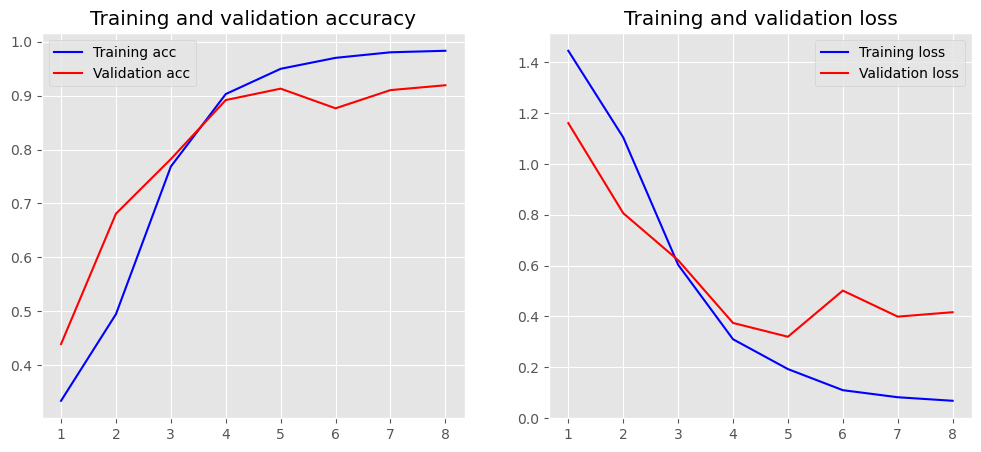

In [9]:
plot_history(history)

In [10]:
checkpoint_path = "cp.ckpt"
model.load_weights(checkpoint_path)
loss, acc = model.evaluate(X_test, y_test, verbose=2)

70/70 - 2s - loss: 0.3905 - accuracy: 0.9212 - 2s/epoch - 27ms/step
